In [22]:
import nltk
#nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

In [23]:
# imports
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# stopwords import
from nltk.corpus import stopwords

# wordcloud for visualization
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,7)

# import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# import Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_auc_score, roc_curve

# Data Exploration and preprocessing

In [40]:
true = pd.read_csv('data/True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [41]:
fake = pd.read_csv('data/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [42]:
true.shape, fake.shape

((21417, 4), (23481, 4))

In [43]:
# combining the title and text of the news together
true['text_combined'] = true['title'].astype(str) + '. ' + true['text'].astype(str)
fake['text_combined'] = fake['title'].astype(str) + '. ' + fake['text'].astype(str)

# Adding target column to both datasets true = 0, fake = 1
true['target'] = 0
fake['target'] = 1

# Combining both dataframes
news = pd.concat([true, fake], axis = 0, ignore_index=True)
news.head()

,title,text,subject,date,text_combined,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...,0


In [45]:
news.shape

(44898, 6)

After combining real and fake news dataset
- Number of rows : 44898
- Number of columns : 5

In [46]:
news['target'].value_counts()

1    23481
0    21417
Name: target, dtype: int64

In [47]:
news['target'].value_counts(normalize = True)

1    0.522985
0    0.477015
Name: target, dtype: float64

In [48]:
news['text_combined'].head()

0    As U.S. budget fight looms, Republicans flip t...
1    U.S. military to accept transgender recruits o...
2    Senior U.S. Republican senator: 'Let Mr. Muell...
3    FBI Russia probe helped by Australian diplomat...
4    Trump wants Postal Service to charge 'much mor...
Name: text_combined, dtype: object

Since target proportion is not skewed, the evaluation metric will be accuracy.

# Text Cleaning

In [49]:
# nltk english stopwords
stop_words = set(stopwords.words('english'))

# wordcloud stopwords
wordcloud_stopwords = set(STOPWORDS)

# combining both stopwords to get better collection of stopwords
stop_words = stop_words | wordcloud_stopwords

# instantiating WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [50]:
len(stop_words)

227

In [51]:
# Wrangling text : removing punctuations, extra spaces, extra dots, converting to lower case
def wrangle(text):
    # replacing U.S. with 'United States'
    text = text.replace('U.S.', 'United States')
    
    # replacing all special characters except '.' with ' '(space) and numbers
    text = re.sub(r"[^a-zA-Z]", ' ', text)
    
    # replace multiple spaces with single space
    text = re.sub(' +', ' ', text)
    
    text = text.strip()
    
    text = text.lower()
    
    return text

# # lemmatization of words
# def getLemmatizedSentence(text):
#     tokens = word_tokenize(text)
#     lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
#     return ' '.join(lemmatized_tokens)
    
# removing stop words
def stopwords_removal(text):
    tokens = word_tokenize(text)
    clean_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(clean_tokens)
    return text

In [52]:
wrangled_news = news['text_combined'][0]
no_words = len(wrangled_news.split(' '))
print('raw text {}'.format(no_words))

wrangled_news = wrangle(news['text_combined'][0])
no_words = len(wrangled_news.split(' '))
print('wrangled text {}'.format(no_words))

wrangled_news = stopwords_removal(wrangled_news)
no_words = len(wrangled_news.split(' '))
print('stopwords removed {}'.format(no_words))

raw text 763
wrangled text 758
stopwords removed 446


# Combining everything together

In [53]:
# Word Tokenization
def textProcessing(text):
    text = wrangle(text)
    text = stopwords_removal(text)
#     text = text.lower()
    return text

# Data Visualization

In [54]:
true['processedText'] = true['text_combined'].apply(textProcessing)
fake['processedText'] = fake['text_combined'].apply(textProcessing)

In [55]:
true['processedText'].head()

0    united states budget fight looms republicans f...
1    united states military accept transgender recr...
2    senior united states republican senator let mr...
3    fbi russia probe helped australian diplomat ti...
4    trump wants postal service charge much amazon ...
Name: processedText, dtype: object

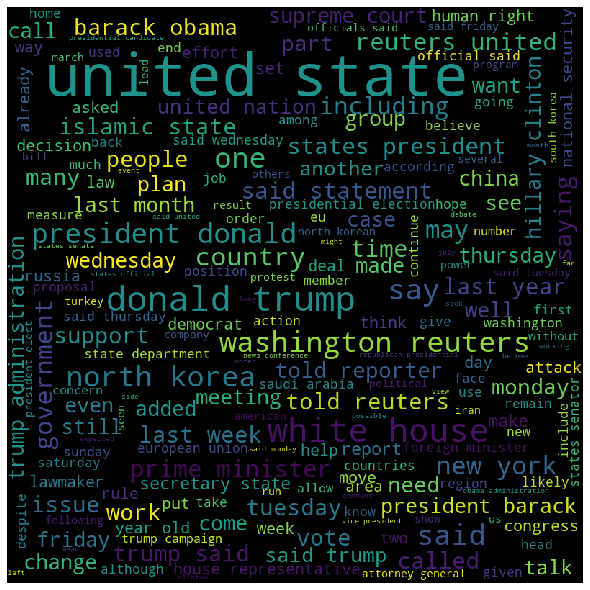

In [38]:
# Wordcloud for True news articles
all_words = ' '
for i in true['processedText']:
    all_words += i + ' '


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(all_words)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

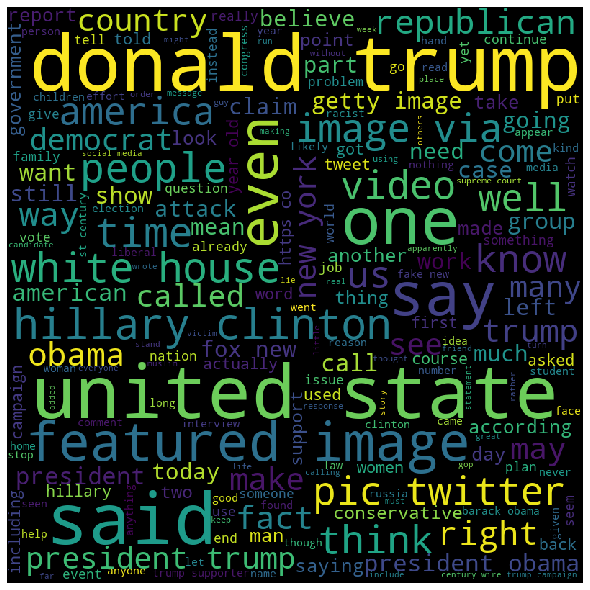

In [56]:
# Wordcloud for Fake news articles
all_words = ''
for i in fake['processedText']:
    all_words += i + ' '


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(all_words)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

# ETL Pipeline

In [57]:
def load_data(col_name = 'text'):
    # Extract
    true = pd.read_csv('data/True.csv')
    fake = pd.read_csv('data/Fake.csv')
    
    # Adding target column to both datasets true = 0, fake = 1
    true['target'] = 0
    fake['target'] = 1
    
    # Combining both dataframes
    news = pd.concat([true, fake], axis = 0).reset_index(drop=True)
    
    # combining the title and text of the news together
    news['text_combined'] = news['title'].astype(str) + ' . ' + news['text'].astype(str)
    
    # clean the data
    news['processed_text'] = news[col_name].apply(textProcessing)
    
    X = news['processed_text']
    y = news['target']
    return X, y

# ML Pipeline

In [58]:
# PipeLine function
def build_model(classifier):
    pipeline = Pipeline([
                ('vect', TfidfVectorizer(stop_words=stop_words, lowercase=True)),
                ('clf', eval(classifier))
            ])

    return pipeline

## Applying separate classifier on title and text

### Title

In [59]:
X, y = load_data('title')
# vect = TfidfVectorizer(stop_words=stop_words, lowercase=True)
# X = vect.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=4)

accuracy_title = {}

# LogisticRegression
pipeline = build_model(classifier='LogisticRegression()')
log_reg = pipeline.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

log_reg_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of LogisticRegression model on title : {}'.format(log_reg_accuracy))
accuracy_title['LogisticRegression'] = round(log_reg_accuracy,3)

# RandomForestClassifier
pipeline = build_model(classifier='RandomForestClassifier()')
model_rf = pipeline.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
rf_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of RandomForestClassifier model on title : {}'.format(rf_accuracy))
accuracy_title['RandomForestClassifier'] = round(rf_accuracy,3)

# DecisionTreeClassifier()
pipeline = build_model(classifier='DecisionTreeClassifier()')
model_dc = pipeline.fit(X_train, y_train)
y_pred = model_dc.predict(X_test)
dc_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of DecisionTreeClassifier model on title : {}'.format(dc_accuracy))
accuracy_title['DecisionTreeClassifier'] = round(dc_accuracy,3)

# KNeighborsClassifier
pipeline = build_model(classifier='KNeighborsClassifier()')
model_knn = pipeline.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
knn_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of KNeighborsClassifier model on title : {}'.format(knn_accuracy))
accuracy_title['KNeighborsClassifier'] = round(knn_accuracy,3)

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of LogisticRegression model on title : 0.9458797327394209


C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of RandomForestClassifier model on title : 0.9409799554565702


C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of DecisionTreeClassifier model on title : 0.9025241276911655


C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of KNeighborsClassifier model on title : 0.8896807720861173


### Text

In [60]:
X, y = load_data('text')
# vect = TfidfVectorizer(stop_words=stop_words, lowercase=True)
# X = vect.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=4)

accuracy_text = {}

# LogisticRegression
pipeline = build_model(classifier='LogisticRegression()')
log_reg = pipeline.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

log_reg_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of LogisticRegression model on title : {}'.format(log_reg_accuracy))
accuracy_text['LogisticRegression'] = round(log_reg_accuracy,3)

# RandomForestClassifier
pipeline = build_model(classifier='RandomForestClassifier()')
model_rf = pipeline.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
rf_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of RandomForestClassifier model on title : {}'.format(rf_accuracy))
accuracy_text['RandomForestClassifier'] = round(rf_accuracy,3)

# DecisionTreeClassifier()
pipeline = build_model(classifier='DecisionTreeClassifier()')
model_dc = pipeline.fit(X_train, y_train)
y_pred = model_dc.predict(X_test)
dc_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of DecisionTreeClassifier model on title : {}'.format(dc_accuracy))
accuracy_text['DecisionTreeClassifier'] = round(dc_accuracy,3)

# KNeighborsClassifier
pipeline = build_model(classifier='KNeighborsClassifier()')
model_knn = pipeline.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
knn_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of KNeighborsClassifier model on title : {}'.format(knn_accuracy))
accuracy_text['KNeighborsClassifier'] = round(knn_accuracy,3)

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of LogisticRegression model on title : 0.9852264291017075


C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of RandomForestClassifier model on title : 0.9913140311804008


C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of DecisionTreeClassifier model on title : 0.99547141796585


C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of KNeighborsClassifier model on title : 0.6380846325167038


### Combine text and title for better prediction

In [61]:
X, y = load_data('text_combined')
# vect = TfidfVectorizer(stop_words=stop_words, lowercase=True)
# X = vect.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=4)

accuracy_combined = {}

# LogisticRegression
pipeline = build_model(classifier='LogisticRegression()')
log_reg = pipeline.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

log_reg_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of LogisticRegression model on title : {}'.format(log_reg_accuracy))
accuracy_combined['LogisticRegression'] = round(log_reg_accuracy,3)

# RandomForestClassifier
pipeline = build_model(classifier='RandomForestClassifier()')
model_rf = pipeline.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
rf_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of RandomForestClassifier model on title : {}'.format(rf_accuracy))
accuracy_combined['RandomForestClassifier'] = round(rf_accuracy,3)

# DecisionTreeClassifier()
pipeline = build_model(classifier='DecisionTreeClassifier()')
model_dc = pipeline.fit(X_train, y_train)
y_pred = model_dc.predict(X_test)
dc_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of DecisionTreeClassifier model on title : {}'.format(dc_accuracy))
accuracy_combined['DecisionTreeClassifier'] = round(dc_accuracy,3)

# KNeighborsClassifier
pipeline = build_model(classifier='KNeighborsClassifier()')
model_knn = pipeline.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
knn_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print('accuracy of KNeighborsClassifier model on title : {}'.format(knn_accuracy))
accuracy_combined['KNeighborsClassifier'] = round(knn_accuracy,3)

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of LogisticRegression model on title : 0.985894580549369


C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of RandomForestClassifier model on title : 0.9930957683741648


C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of DecisionTreeClassifier model on title : 0.995916852264291


C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy of KNeighborsClassifier model on title : 0.8778767631774314


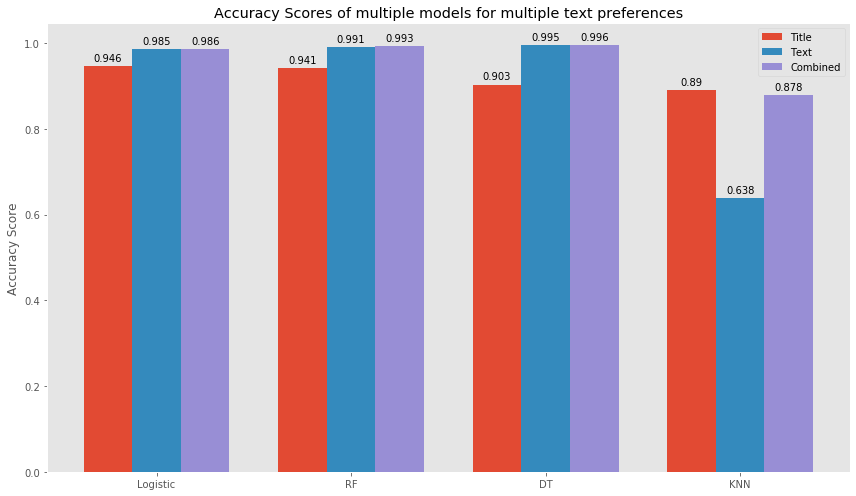

In [62]:
labels = ['Logistic', 'RF', 'DT', 'KNN']
title = list(accuracy_title.values())
text = list(accuracy_text.values())
combined = list(accuracy_combined.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, title, width, label='Title')
rects2 = ax.bar(x, text, width, label='Text')
rects3 = ax.bar(x + width, combined, width, label='Combined')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy Score')
ax.set_title('Accuracy Scores of multiple models for multiple text preferences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 'best')
ax.grid(b = False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
fig.tight_layout()

plt.show()

Combination of text and title proved to be better for predicting fake or real news

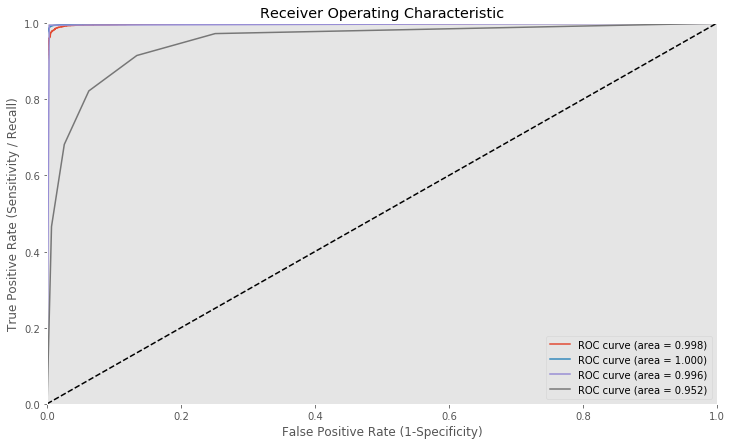

In [63]:
# Plotting AUC scores for multiple models
for model in [log_reg, model_rf, model_dc, model_knn]:
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_score=y_pred_prob, y_true=y_test)
    auc_score = roc_auc_score(y_true=y_test, y_score=y_pred_prob)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc_score)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(b = False)
plt.show()

- Random Forest Classifier with AUC = 1